##  Camada Analítica: Métricas Exploratórias de Negócio

**Objetivo:** Consumir a One Big Table (OBT) da Camada Gold para extrair insights acionáveis sobre o risco de crédito..

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv, find_dotenv

In [2]:
# Carrega ambiente
load_dotenv(find_dotenv())
GOLD_PATH = os.getenv("GOLD_DATA_PATH", "../data/gold")

In [3]:
# Carga da Tabela Analítica Final (OBT)

df_gold = pd.read_parquet(os.path.join(GOLD_PATH, "analytics_credit_risk_train.parquet"))

print(f"Dimensões da OBT: {df_gold.shape[0]} linhas e {df_gold.shape[1]} features.")
taxa_global = df_gold['target'].mean()
print(f"Taxa de Inadimplência Global (Default Rate): {taxa_global:.2%}")


Dimensões da OBT: 307511 linhas e 177 features.
Taxa de Inadimplência Global (Default Rate): 8.07%


C:\Users\mvcor\AppData\Local\Temp\ipykernel_1780\2430416951.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_contract = df_gold.groupby('name_contract_type').agg(
C:\Users\mvcor\AppData\Local\Temp\ipykernel_1780\2430416951.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_contract, x='name_contract_type', y='taxa_default_pct', palette='Set2')


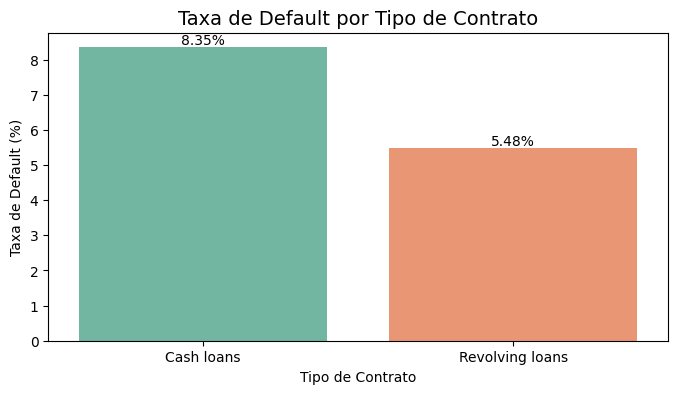

,name_contract_type,total_pedidos,taxa_default
0,Cash loans,278232,0.083459
1,Revolving loans,29279,0.054783


In [4]:

# Métrica 1: Taxa de Default por Tipo de Contrato
# Vamos analisar se empréstimos em dinheiro vivo são mais arriscados que crédito rotativo.

# Agrupamento por Tipo de Contrato
df_contract = df_gold.groupby('name_contract_type').agg(
    total_pedidos=('sk_id_curr', 'count'),
    taxa_default=('target', 'mean')
).reset_index()

# Formatação visual
df_contract['taxa_default_pct'] = df_contract['taxa_default'] * 100

plt.figure(figsize=(8, 4))
ax = sns.barplot(data=df_contract, x='name_contract_type', y='taxa_default_pct', palette='Set2')
plt.title('Taxa de Default por Tipo de Contrato', fontsize=14)
plt.ylabel('Taxa de Default (%)')
plt.xlabel('Tipo de Contrato')

# Adiciona os rótulos
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

display(df_contract[['name_contract_type', 'total_pedidos', 'taxa_default']])



C:\Users\mvcor\AppData\Local\Temp\ipykernel_1780\2114392255.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_renda = df_gold.groupby('faixa_renda').agg(


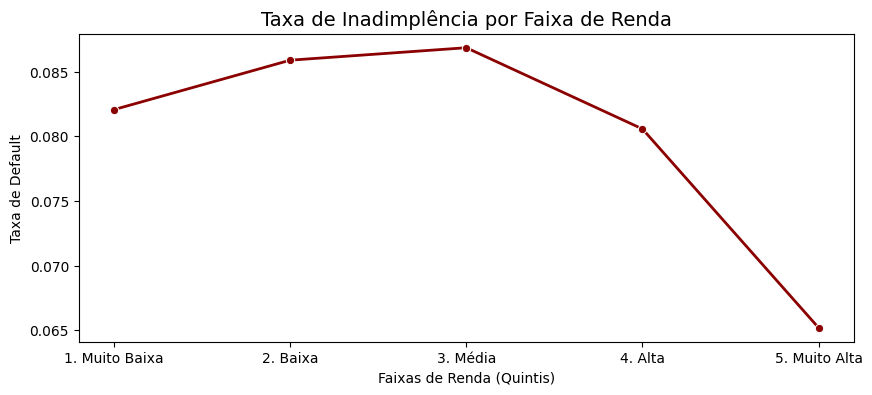

,faixa_renda,taxa_default,media_renda_faixa
0,1. Muito Baixa,0.082062,78064.972119
1,2. Baixa,0.085883,123021.589719
2,3. Média,0.086847,155407.425275
3,4. Alta,0.080569,198635.725640
4,5. Muito Alta,0.065198,336976.605008


In [ ]:

# Métrica 2: Taxa de Default por Faixa de Renda
# Segmentando a renda dos clientes em 5 faixas (Quintis) para entender se maior renda significa menor risco.

# Criando faixas de renda usando qcut (Quintis: divide a base em 5 partes iguais)
df_gold['faixa_renda'] = pd.qcut(df_gold['amt_income_total'], q=5, 
                                 labels=['1. Muito Baixa', '2. Baixa', '3. Média', '4. Alta', '5. Muito Alta'])

df_renda = df_gold.groupby('faixa_renda').agg(
    taxa_default=('target', 'mean'),
    media_renda_faixa=('amt_income_total', 'mean')
).reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_renda, x='faixa_renda', y='taxa_default', marker='o', linewidth=2, color='darkred')
plt.title('Taxa de Inadimplência por Faixa de Renda', fontsize=14)
plt.ylabel('Taxa de Default')
plt.xlabel('Faixas de Renda (Quintis)')
plt.show()

display(df_renda)

C:\Users\mvcor\AppData\Local\Temp\ipykernel_1780\2542417542.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_idade = df_gold.groupby('faixa_etaria').agg(
C:\Users\mvcor\AppData\Local\Temp\ipykernel_1780\2542417542.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_idade, x='faixa_etaria', y='taxa_default', palette='Blues_r')


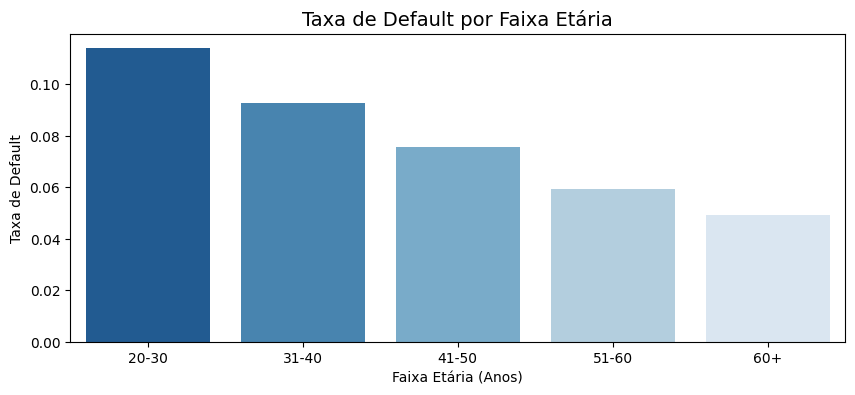

Idade Média dos Bons Pagadores: 44.2 anos
Idade Média dos Maus Pagadores: 40.8 anos


In [6]:

#  Métrica 3: Idade Média e Impacto no Risco
# A idade avançada mitiga o risco de crédito?

# Arredondando a idade (calculada na Fase 2) para anos inteiros
df_gold['idade_anos_inteiros'] = df_gold['years_birth'].astype(int)

# Criando faixas etárias padrão de mercado
bins_idade = [20, 30, 40, 50, 60, 100]
labels_idade = ['20-30', '31-40', '41-50', '51-60', '60+']
df_gold['faixa_etaria'] = pd.cut(df_gold['idade_anos_inteiros'], bins=bins_idade, labels=labels_idade)

df_idade = df_gold.groupby('faixa_etaria').agg(
    taxa_default=('target', 'mean'),
    total_clientes=('sk_id_curr', 'count')
).reset_index()

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=df_idade, x='faixa_etaria', y='taxa_default', palette='Blues_r')
plt.title('Taxa de Default por Faixa Etária', fontsize=14)
plt.ylabel('Taxa de Default')
plt.xlabel('Faixa Etária (Anos)')
plt.show()

print(f"Idade Média dos Bons Pagadores: {df_gold[df_gold['target']==0]['years_birth'].mean():.1f} anos")
print(f"Idade Média dos Maus Pagadores: {df_gold[df_gold['target']==1]['years_birth'].mean():.1f} anos")


C:\Users\mvcor\AppData\Local\Temp\ipykernel_1780\379733724.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_score = df_gold.groupby('faixa_score_externo')['target'].mean().reset_index()
C:\Users\mvcor\AppData\Local\Temp\ipykernel_1780\379733724.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_score, x='faixa_score_externo', y='target', palette='magma')


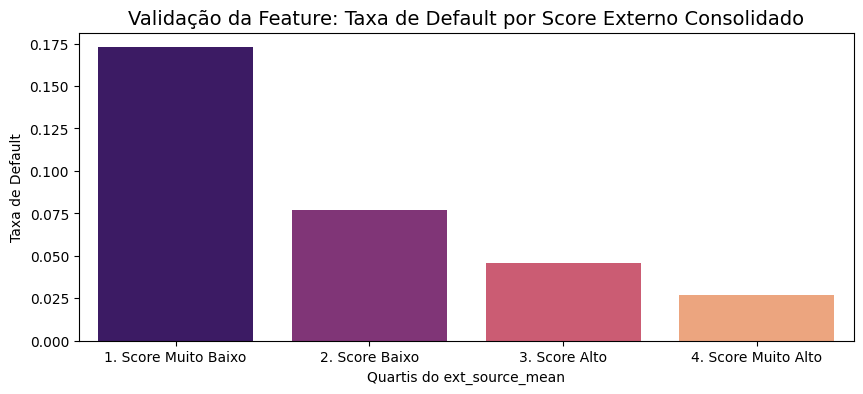

In [7]:

# Métrica 4: O poder da nossa Feature de Risco Externo
# Vamos testar se a feature `ext_source_mean` que criamos na Fase 2 realmente prevê o risco.

# Criando quartis para o score externo consolidado
df_gold['faixa_score_externo'] = pd.qcut(df_gold['ext_source_mean'], q=4, 
                                         labels=['1. Score Muito Baixo', '2. Score Baixo', '3. Score Alto', '4. Score Muito Alto'])

df_score = df_gold.groupby('faixa_score_externo')['target'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(data=df_score, x='faixa_score_externo', y='target', palette='magma')
plt.title('Validação da Feature: Taxa de Default por Score Externo Consolidado', fontsize=14)
plt.ylabel('Taxa de Default')
plt.xlabel('Quartis do ext_source_mean')
plt.show()